# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [454]:
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime
%matplotlib inline
import scipy.stats as st
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [398]:
df = pd.read_csv('data/flights_cleaned.csv')

In [399]:
df.head()

,fl_date,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,dep_time,...,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2018-05-31,WN,WN,2081,BUR,"Burbank, CA",SFO,"San Francisco, CA",1100,1138.0,...,51.0,80,93.0,68.0,326,0.0,0.0,51.0,0.0,0.0
1,2019-04-20,AA,AA,2244,ORD,"Chicago, IL",DFW,"Dallas/Fort Worth, TX",1311,1303.0,...,-35.0,153,126.0,101.0,801,0.0,0.0,0.0,0.0,0.0
2,2019-02-13,WN,WN,1731,MSY,"New Orleans, LA",HOU,"Houston, TX",2130,2159.0,...,18.0,75,64.0,55.0,302,0.0,0.0,0.0,0.0,18.0
3,2018-11-20,AA,AA,2620,DFW,"Dallas/Fort Worth, TX",IND,"Indianapolis, IN",1834,1833.0,...,13.0,128,142.0,102.0,761,0.0,0.0,0.0,0.0,0.0
4,2018-08-28,DL,9E,4060,JFK,"New York, NY",IAD,"Washington, DC",1359,1353.0,...,-34.0,98,70.0,51.0,228,0.0,0.0,0.0,0.0,0.0


In [400]:
# df.info()

In [401]:
#remove outliers for arr_delay using IQR
cols = ['arr_delay']

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [402]:
# df.info()

In [403]:
# # correlation analysis -- ignore this, got from website to check things out

# import seaborn as sns
# import matplotlib.pyplot as plt

# #Calculating the mean arrival delays for each airline
# arr_delay_avg = df['arr_delay'].mean()
# carrier_delay_df = pd.DataFrame({'arr_delay_avg' : combined_data_v2.groupby([ "OP_CARRIER"] )['ARR_DELAY'].mean()}).reset_index()

# #Inner join on the airline
# combined_data_v2 = pd.merge(combined_data_v2, airline_delay_df, how='inner', on='OP_CARRIER')

# #Converting flight date to a Datetime object and then computing which weekday the flight was on
# combined_data_v2['FL_DATE']= pd.to_datetime(combined_data_v2['FL_DATE'])
# combined_data_v2['flight_weekday']= combined_data_v2['FL_DATE'].apply(lambda x: x.weekday() + 1)

# #Computing correlation among the columns
# correlation_data =  combined_data_v2
# corr = correlation_data.corr() 


# %matplotlib inline

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [404]:
df.columns

Index(['fl_date', 'mkt_unique_carrier', 'op_unique_carrier',
       'op_carrier_fl_num', 'origin', 'origin_city_name', 'dest',
       'dest_city_name', 'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out',
       'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'distance', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'],
      dtype='object')

In [405]:
df.drop(columns=['origin_city_name',
                 'mkt_unique_carrier',
                 'crs_arr_time',
                 'dest_city_name',
                 'op_carrier_fl_num',
                 'dep_time',
                 'taxi_out',
                 'taxi_in',
                 'arr_time',
                 'crs_elapsed_time',
                 'actual_elapsed_time',
                 'air_time',
                 'distance',
                 'carrier_delay',
                 'weather_delay',
                 'nas_delay',
                 'security_delay',
                 'late_aircraft_delay',
                 'dep_delay'],
        inplace=True)

In [406]:
# convert datetype dtype
df['fl_date'] = pd.to_datetime(df['fl_date'], format='%Y-%m-%d', errors='ignore')

# create new column 'fl_year' and fl_month
df['fl_year'] = df['fl_date'].dt.year
df['fl_month'] = df['fl_date'].dt.month
df['fl_day'] = df['fl_date'].dt.day

In [407]:
df.drop(columns=['fl_date'], inplace=True)

In [408]:
# introduce delay status feature so that classficiation can be made easier
df['delay_status'] = np.nan

for index, row in df.iterrows():
    delay_time = row['arr_delay']
    
    if delay_time <= 5:
        df.at[index,'delay_status'] = 0
    elif (delay_time > 5) and (delay_time <= 30):
        # expect short delay
        df.at[index,'delay_status'] = 1
    elif (delay_time > 30) and (delay_time <= 60):
        # expect long delay
        df.at[index,'delay_status'] = 2
    elif (delay_time > 45):
        # expect very long delay
        df.at[index,'delay_status'] = 3
        
df.head()

,op_unique_carrier,origin,dest,crs_dep_time,arr_delay,fl_year,fl_month,fl_day,delay_status
1,AA,ORD,DFW,1311,-35.0,2019,4,20,0.0
2,WN,MSY,HOU,2130,18.0,2019,2,13,1.0
3,AA,DFW,IND,1834,13.0,2018,11,20,1.0
4,9E,JFK,IAD,1359,-34.0,2018,8,28,0.0
5,OO,SLC,SMF,1535,-7.0,2018,10,30,0.0


In [409]:
# label encoding for categorical 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn import preprocessing

lab_en = preprocessing.LabelEncoder()
df_model = df.copy()
df_model['op_unique_carrier'] = lab_en.fit_transform(df_model['op_unique_carrier'].values)
df_model['origin'] = lab_en.fit_transform(df_model['origin'].values)
df_model['dest'] = lab_en.fit_transform(df_model['dest'].values)

scaler = RobustScaler()
# scaler = preprocessing.StandardScaler()

df_model['crs_dep_time'] = scaler.fit_transform(df_model[['crs_dep_time']])

df_model.drop(columns=['fl_year', 'arr_delay'], inplace=True)

In [410]:
df_model.head()

,op_unique_carrier,origin,dest,crs_dep_time,fl_month,fl_day,delay_status
1,2,253,93,0.013382,4,20,0.0
2,24,240,157,1.009732,2,13,1.0
3,2,94,173,0.649635,11,20,1.0
4,0,181,165,0.071776,8,28,0.0
5,19,328,332,0.285888,10,30,0.0


In [411]:
# from sklearn import preprocessing
# onehot_en = preprocessing.OneHotEncoder()

# df_model = df.copy()
# df_model.drop(columns=['fl_year', 'arr_delay'], inplace=True)

# columns = ['op_unique_carrier', 'origin', 'dest', 'fl_month', 'fl_day']
# df_model = pd.get_dummies(df_model, prefix=columns, columns=columns)

# scaler = RobustScaler()

# df_model['crs_dep_time'] = scaler.fit_transform(df_model[['crs_dep_time']])

In [412]:
df_model.head()

,op_unique_carrier,origin,dest,crs_dep_time,fl_month,fl_day,delay_status
1,2,253,93,0.013382,4,20,0.0
2,24,240,157,1.009732,2,13,1.0
3,2,94,173,0.649635,11,20,1.0
4,0,181,165,0.071776,8,28,0.0
5,19,328,332,0.285888,10,30,0.0


# Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [292]:
# scaling 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import r2_score
from sklearn import metrics

import seaborn as sns; sns.set(style='darkgrid', context='talk')
import matplotlib.pyplot as plt
import pickle

In [293]:
df_model['delay_status'].value_counts()

0.0    141966
1.0     30320
2.0      5624
Name: delay_status, dtype: int64

In [294]:
X = df_model.drop(columns=['delay_status']) # drop delay_status because these are what we want to predict
y = df_model['delay_status'] #target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# X_train_new = pd.DataFrame(X_train).sample(frac = 0.1).values
# y_train_new = pd.DataFrame(y_train).sample(frac = 0.1).values

## Random Forest

In [295]:
# %%time
# rfc = RandomForestClassifier(n_estimators=10, max_depth=7)
# rfc.fit(X_train, y_train)

In [296]:
%%time
from sklearn.model_selection import RandomizedSearchCV as RSCV

param_grid = {'n_estimators' : np.arange(50 ,100, 25),
              'max_features' : np.arange(0.1, 1, 0.1),
              'max_depth': [3, 5, 7, 9],
              'max_samples': [0.3, 0.5, 0.8]}

rfc_model = RSCV(RandomForestClassifier(class_weight='balanced'), param_grid, n_iter = 15).fit(X_train, y_train)
rfc_model = rfc_model.best_estimator_

CPU times: user 2min 53s, sys: 566 ms, total: 2min 54s
Wall time: 2min 55s


In [297]:
rfc_model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(class_weight='balanced', max_depth=9,
                       max_features=0.7000000000000001, max_samples=0.3,
                       n_estimators=75)>

In [298]:
y_rfc = rfc_model.predict(X_test)
y_rfc_proba = rfc_model.predict_proba(X_test)
print("Parameters: ",rfc.score)
print("Accuracy \t{:.3f}".format(metrics.accuracy_score(y_test, y_rfc)))
print('Recall \t\t{:.3f}'.format(metrics.recall_score(y_test, y_rfc, average='weighted')))
print('Precision \t{:.3f}'.format(metrics.precision_score(y_test, y_rfc, average='weighted')))
print('F1 Score \t{:.3f}'.format(metrics.f1_score(y_test, y_rfc, average='weighted')))
print('AUC Score \t{:.3f} '.format(metrics.roc_auc_score(y_test, y_rfc_proba, multi_class='ovo')))

Parameters:  <bound method ClassifierMixin.score of RandomForestClassifier(max_depth=7, n_estimators=10)>
Accuracy 	0.522
Recall 		0.522
Precision 	0.695
F1 Score 	0.587
AUC Score 	0.565 


## XGBOOST

In [413]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import warnings
warnings.filterwarnings('ignore')

In [414]:
def objective(space):
    clf=xgb.XGBClassifier(
        n_estimators = int(space['n_estimators']), 
        max_depth = int(space['max_depth']), gamma = space['gamma'],
        reg_alpha = int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=int(space['colsample_bytree']),
        seed = int(space['seed'])
    )
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    
    return {'loss': -accuracy, 'status': STATUS_OK }

In [415]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.uniform('n_estimators', 100,1000),
        'seed': 123
    }

In [416]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [417]:
trials = Trials()

best_hyperparams = fmin(
    fn = objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 5,
    trials = trials
)

SCORE:                                                                                                        
0.79750997695464                                                                                              
SCORE:                                                                                                        
0.79750997695464                                                                                              
SCORE:                                                                                                        
0.79750997695464                                                                                              
SCORE:                                                                                                        
0.79750997695464                                                                                              
SCORE:                                                                                                        
0

In [418]:
xgb_model = xgb.XGBClassifier(best_hyperparams)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [462]:
preds = xgb_model.predict(X_test)
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
acc_xgb_proba = xgb_model.predict_proba(X_test)

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Accuracy \t{:.3f}".format(metrics.accuracy_score(y_test, preds)))
print('Recall \t\t{:.3f}'.format(metrics.recall_score(y_test, preds, average='weighted')))
print('Precision \t{:.3f}'.format(metrics.precision_score(y_test, preds, average='weighted')))
print('F1 Score \t{:.3f}'.format(metrics.f1_score(y_test, preds, average='weighted')))
# print('AUC Score \t{:.3f} '.format(metrics.roc_auc_score(y_test, y_rfc_proba, multi_class='ovo')))

XGBoost's prediction accuracy is: 79.69
Accuracy 	0.797
Recall 		0.797
Precision 	0.668
F1 Score 	0.708


In [71]:
# ## Decision tree classifier comparison 
# from sklearn.tree import DecisionTreeClassifier

# dtc = DecisionTreeClassifier()  # initialize DecisionTreeClassifier

In [394]:
# # fit model into training set
# dtc.fit(X_train,y_train)


In [395]:
# # test model 
# y_pred2 = dtc.predict(X_test)
# y_pred2

In [74]:
# print("Accuracy of Model::",accuracy_score(y_test,y_pred2))

Accuracy of Model:: 0.023772715339964414


In [176]:
# # we need to initialize XGboost
# xgb_classifier = xgb.XGBClassifier()

# # train model
# xgb_classifier.fit(X_train,y_train)

In [ ]:
# # make predictions using XGboost
# predictions = xgb_classifier.predict(X_test)
# predictions

## SVM -- to ignore for now

In [396]:
# %%time
# svr_params = {'kernel': ['linear','rbf','poly'],
#               'C': [1, 5, 10],
#               'gamma': [0.0000001, 0.00001, 0.001, 0.1, 1],
#               'epsilon': [0.1, 0.2, 0.3, 0.5 ]
#              }
# grid_svr = GridSearchCV(SVR(), svr_params, cv=3, verbose=1, n_jobs=-1)
# grid_svr.fit(X_train_new, y_train_new)
# svr = grid_svr.best_estimator_
# svr.get_params

# Loading Flight Test Data

In [421]:
df_test = pd.read_csv('data/flights_test.csv')

In [422]:
df_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance
0,1577865600000,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363
1,1577865600000,WN,WN,WN,6276,WN,N467WN,6276,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363
2,1577865600000,WN,WN,WN,4598,WN,N7885A,4598,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",2020,2130,N,70,1,333
3,1577865600000,WN,WN,WN,4761,WN,N551WN,4761,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",1340,1455,N,75,1,333
4,1577865600000,WN,WN,WN,5162,WN,N968WN,5162,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",915,1035,N,80,1,333


In [423]:
df_test['fl_date'].dtype

dtype('int64')

In [424]:
df_test.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time',
       'crs_arr_time', 'dup', 'crs_elapsed_time', 'flights', 'distance'],
      dtype='object')

In [425]:
# convert datetype dtype
df_model_test = df_test.copy()
df_model_test['fl_date'] = pd.to_datetime(df_model_test['fl_date'], unit='ms')

# create new column 'fl_year' and fl_month
# extract year 
df_model_test['fl_year'] = df_model_test['fl_date'].dt.year
df_model_test['fl_month'] = df_model_test['fl_date'].dt.month
df_model_test['fl_day'] = df_model_test['fl_date'].dt.day

df_model_test.drop(columns=['fl_date'], inplace=True)
df_model_test.head()

,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,...,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,fl_year,fl_month,fl_day
0,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,"Ontario, CA",...,"San Francisco, CA",1810,1945,N,95,1,363,2020,1,1
1,WN,WN,WN,6276,WN,N467WN,6276,13891,ONT,"Ontario, CA",...,"San Francisco, CA",1150,1320,N,90,1,363,2020,1,1
2,WN,WN,WN,4598,WN,N7885A,4598,13891,ONT,"Ontario, CA",...,"San Jose, CA",2020,2130,N,70,1,333,2020,1,1
3,WN,WN,WN,4761,WN,N551WN,4761,13891,ONT,"Ontario, CA",...,"San Jose, CA",1340,1455,N,75,1,333,2020,1,1
4,WN,WN,WN,5162,WN,N968WN,5162,13891,ONT,"Ontario, CA",...,"San Jose, CA",915,1035,N,80,1,333,2020,1,1


In [426]:
df_model_test.drop(columns=[
                 'mkt_unique_carrier',
                 'branded_code_share',
                 'mkt_carrier',
                 'mkt_carrier_fl_num',
                 'tail_num',
                 'op_carrier_fl_num',
                 'origin_airport_id',
                 'origin_city_name',
                 'dest_airport_id',
                 'dest_city_name',
                 'dup',
                 'crs_elapsed_time',
                 'flights',
                 'distance',
                 'fl_year',
                 'crs_arr_time'],
        inplace=True)
df_model_test.head()

,op_unique_carrier,origin,dest,crs_dep_time,fl_month,fl_day
0,WN,ONT,SFO,1810,1,1
1,WN,ONT,SFO,1150,1,1
2,WN,ONT,SJC,2020,1,1
3,WN,ONT,SJC,1340,1,1
4,WN,ONT,SJC,915,1,1


In [427]:
# op_unique_carrier	origin	dest	crs_dep_time	fl_month	fl_day	delay_status

In [428]:
# label encoding for categorical 
from sklearn import preprocessing

lab_en = preprocessing.LabelEncoder()

df_model_test['op_unique_carrier'] = lab_en.fit_transform(df_model_test['op_unique_carrier'].values)
df_model_test['origin'] = lab_en.fit_transform(df_model_test['origin'].values)
df_model_test['dest'] = lab_en.fit_transform(df_model_test['dest'].values)

scaler = RobustScaler()

df_model_test['crs_dep_time'] = scaler.fit_transform(df_model_test[['crs_dep_time']])

df_model_test.head()

,op_unique_carrier,origin,dest,crs_dep_time,fl_month,fl_day
0,21,246,312,0.592186,1,1
1,21,246,312,-0.213675,1,1
2,21,246,318,0.848596,1,1
3,21,246,318,0.018315,1,1
4,21,246,318,-0.500611,1,1


In [429]:
df_model_test

,op_unique_carrier,origin,dest,crs_dep_time,fl_month,fl_day
0,21,246,312,0.592186,1,1
1,21,246,312,-0.213675,1,1
2,21,246,318,0.848596,1,1
3,21,246,318,0.018315,1,1
4,21,246,318,-0.500611,1,1
...,...,...,...,...,...,...
199995,7,318,321,-0.368742,1,10
199996,7,20,42,0.273504,1,10
199997,7,42,20,0.383394,1,10
199998,7,71,99,0.831502,1,10


# XGBoost Classifier Testing

In [446]:
test_y_xgb = xgb_model.predict(df_model_test)

In [447]:
df_test_delay_status = pd.DataFrame(test_y_xgb, columns=['delay_status'])

In [450]:
for index, row in df_test_delay_status.iterrows():
    delay_status = row['delay_status']
    
    if delay_status == 0:
        df_test_delay_status.at[index,'delay_status'] = "No Delay (0-5mins)"
    elif delay_status == 1.0:
        # expect short delay
        df_test_delay_status.at[index,'delay_status'] = "Short Delay (5-30mins)"
    elif delay_status == 2.0:
        # expect long delay
        df_test_delay_status.at[index,'delay_status'] = "Long Delay (30-60mins)"

In [451]:
df_test_delay_status.value_counts()

delay_status          
No Delay (0-5mins)        199811
Short Delay (5-30mins)       188
Long Delay (30-60mins)         1
dtype: int64

In [452]:
# create value_counts dataframe; want count of flights; op_unique_carrier is the unique flight carrier
df_test_delay_status = df_test_delay_status['delay_status'].value_counts().rename_axis('delay_status').reset_index(name='delay_count')
df_test_delay_status

,delay_status,delay_count
0,No Delay (0-5mins),199811
1,Short Delay (5-30mins),188
2,Long Delay (30-60mins),1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


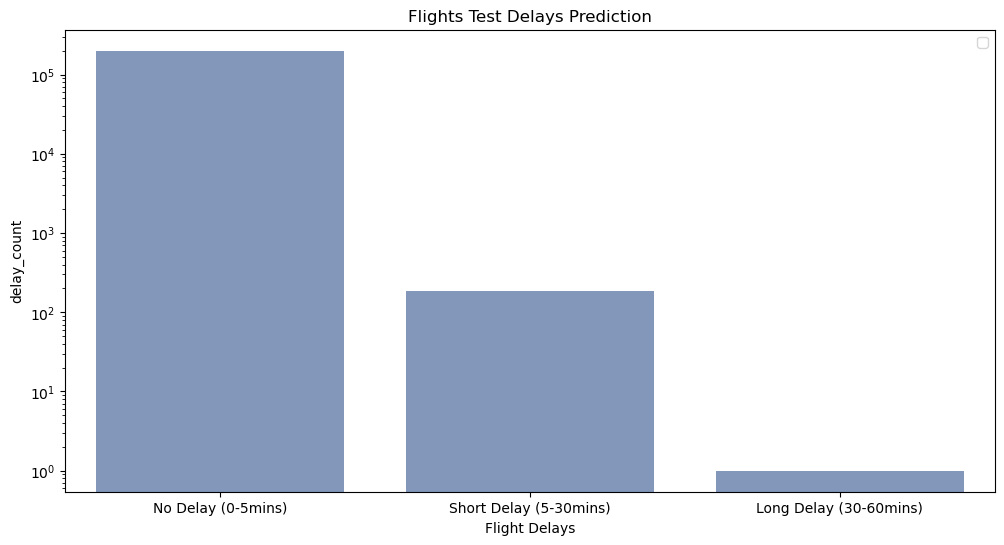

In [460]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

graph = sns.barplot(data = df_test_delay_status, x='delay_status', y='delay_count', alpha=0.75, ax=ax1, color = 'b')
graph.set_yscale("log")
graph.set(xlabel = "Flight Delays", title ='Flights Test Delays Prediction')

ax1.legend()

In [389]:
df_test_result = pd.concat([df_test, df_test_delay_status], axis=1)

In [391]:
df_test_result_w_delay = df_test_result[df_test_result['delay_status'] > 0] 

In [392]:
df_test_result_w_delay

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,delay_status
83,1577865600000,WN,WN,WN,2029,21,N456WN,2029,14107,262,...,10140,2,"Albuquerque, NM",0.598291,1920,N,65,1,328,1
86,1577865600000,WN,WN,WN,5099,21,N732SW,5099,14107,262,...,10140,2,"Albuquerque, NM",0.109890,1520,N,65,1,328,1
359,1577865600000,WN,WN,WN,5982,21,N757LV,5982,14679,299,...,10140,2,"Albuquerque, NM",0.866911,2315,N,100,1,628,1
1288,1577865600000,AA,AA_CODESHARE,AA,4205,14,N840AE,4205,11298,92,...,10136,1,"Abilene, TX",-0.335775,1158,N,68,1,158,1
1808,1577865600000,AA,AA_CODESHARE,AA,5076,16,N516AE,5076,11057,71,...,10980,63,"Chattanooga, TN",0.525031,1911,N,76,1,241,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174388,1578556800000,AA,AA_CODESHARE,AA,4552,23,N119HQ,4552,11057,71,...,15919,358,"Fayetteville, AR",0.023199,1510,N,146,1,754,1
176901,1578556800000,G4,G4,G4,2696,11,242NV,2696,10466,26,...,15919,358,"Fayetteville, AR",0.240537,1847,N,145,1,1006,1
181717,1578556800000,UA,UA_CODESHARE,UA,6162,22,N83329,6162,12266,162,...,15919,358,"Fayetteville, AR",0.119658,1604,N,101,1,438,1
194065,1578556800000,AA,AA_CODESHARE,AA,4382,23,N441YX,4382,14100,261,...,15919,358,"Fayetteville, AR",0.239316,1744,N,203,1,1066,1


# RandomForest Classifier Testing

In [375]:
test_y_rfc = rfc_model.predict(df_test)

In [376]:
df_test_rfc_delay_status = pd.DataFrame(test_y_rfc, columns=['delay_status'])

In [377]:
df_test_rfc_delay_status.value_counts()

delay_status
0.0             110353
1.0              48300
2.0              41347
dtype: int64

In [ ]:
df.info()

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

In [147]:
df_test = pd.read_csv('data/flights_test.csv')

In [148]:
df_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance
0,1577865600000,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363
1,1577865600000,WN,WN,WN,6276,WN,N467WN,6276,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363
2,1577865600000,WN,WN,WN,4598,WN,N7885A,4598,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",2020,2130,N,70,1,333
3,1577865600000,WN,WN,WN,4761,WN,N551WN,4761,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",1340,1455,N,75,1,333
4,1577865600000,WN,WN,WN,5162,WN,N968WN,5162,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",915,1035,N,80,1,333


======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.